# Sarcasm Detection using Pretrained Language Models

This notebook implements sarcasm detection on Reddit political comments using transformer-based pretrained language models.

In [1]:
from google.colab import drive
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import random
import re
import json
import time
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
drive.mount("/content/drive")
base_dir = "/content/drive/MyDrive/SarcasmDetection"
sys.path.append(base_dir)
os.chdir(base_dir)

# Data paths
train_data_balanced_path = os.path.join(base_dir, "train-balanced-sarcasm.csv")
test_data_balanced_path = os.path.join(base_dir, "test-balanced.csv")
test_data_unbalanced_path = os.path.join(base_dir, "test-unbalanced.csv")

# Create output directory for model artifacts
output_dir = os.path.join(base_dir, "roberta_model")
os.makedirs(output_dir, exist_ok=True)

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Using device: cuda
PyTorch version: 2.6.0+cu124
Transformers version: 4.51.3
Mounted at /content/drive


## 1. Data Preprocessing

In [2]:
train_data = pd.read_csv(train_data_balanced_path)

# Get data from political subreddits only
political_subreddits = [
    "politics", "news", "worldnews", "HillaryForPrison", "progressive", "The_Donald",
    "ukpolitics", "conspiracy", "Libertarian", "worldpolitics", "EnoughTrumpSpam",
    "FULLCOMMUNISM", "WayOfTheBern", "PoliticalDiscussion", "uncensorednews",
    "LateStageCapitalism", "Anarchism", "Conservative", "DNCleaks", "TopMindsOfReddit",
    "Republican", "PoliticalVideo", "AskAnAmerican", "AmericanPolitics", "DebateFascism",
    "socialism", "Anarcho_Capitalism", "GenderCritical", "AskThe_Donald",
    "EnoughLibertarianSpam", "CanadaPolitics"
]

train_data = train_data[train_data['subreddit'].isin(political_subreddits)]
train_data = train_data.dropna(subset=['subreddit', 'comment', 'label', 'subreddit'])
train_data['comment_length'] = train_data['comment'].apply(len)

train_df, test_df = train_test_split(train_data, test_size=0.2, random_state=seed, stratify=train_data['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=seed, stratify=train_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 70986
Validation set size: 17747
Test set size: 22184


<ipython-input-2-ea237107f5bb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['comment_length'] = train_data['comment'].apply(len)


## 3. Dataset Class and Tokenization


In [3]:
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
class SarcasmDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len=128):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = str(self.comments[idx])
        label = self.labels[idx]

        # Truncate and tokenize
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SarcasmDataset(
    train_df['comment'].values,
    train_df['label'].values,
    tokenizer
)

val_dataset = SarcasmDataset(
    val_df['comment'].values,
    val_df['label'].values,
    tokenizer
)

test_dataset = SarcasmDataset(
    test_df['comment'].values,
    test_df['label'].values,
    tokenizer
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

#### Tokenization Visualization

In [4]:
def visualize_tokenization(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text, add_special_tokens=True)
    token_colors = plt.cm.viridis(np.linspace(0, 1, len(tokens)))

    fig = go.Figure()

    # Add tokens as the main text
    for i, (token, color) in enumerate(zip(tokens, token_colors)):
        color_hex = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'
        fig.add_trace(go.Scatter(
            x=[i],
            y=[0],
            mode='markers+text',
            marker=dict(size=30, color=color_hex, opacity=0.7),
            text=token,
            textposition="middle center",
            showlegend=False
        ))

    # Add token IDs below
    for i, token_id in enumerate(token_ids[1:-1]):
        fig.add_annotation(
            x=i,
            y=-0.5,
            text=str(token_id),
            showarrow=False,
            font=dict(size=10)
        )

    # Add special tokens separately
    fig.add_annotation(
        x=-0.5,
        y=0,
        text=tokenizer.convert_ids_to_tokens(token_ids[0]),
        showarrow=False,
        font=dict(size=12, color="red")
    )

    fig.add_annotation(
        x=len(tokens) - 0.5,
        y=0,
        text=tokenizer.convert_ids_to_tokens(token_ids[-1]),
        showarrow=False,
        font=dict(size=12, color="red")
    )

    fig.update_layout(
        title={
            'text': "RoBERTa Tokenization Example",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis=dict(
            title="Token Position",
            showticklabels=False
        ),
        yaxis=dict(
            title="",
            showticklabels=False,
            range=[-1, 1]
        ),
        height=250,
        margin=dict(l=20, r=20, t=50, b=20),
        plot_bgcolor='white'
    )
    return fig

sarcastic_example = train_df[train_df['label'] == 1]['comment'].iloc[20]
non_sarcastic_example = train_df[train_df['label'] == 0]['comment'].iloc[20]

print("\nSarcastic Example:")
print(sarcastic_example)
sarcastic_tokenization = visualize_tokenization(sarcastic_example, tokenizer)
sarcastic_tokenization.show()

print("\nNon-Sarcastic Example:")
print(non_sarcastic_example)
non_sarcastic_tokenization = visualize_tokenization(non_sarcastic_example, tokenizer)
non_sarcastic_tokenization.show()


Sarcastic Example:
oh yeah you are the rational one thinking Obama wants to help Al Qaeda.



Non-Sarcastic Example:
At least he answered, unlike Carly


## 4. Transformer Model Implementation



#### Data Loaders

In [5]:
batch_size = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

#### Get Pretrained Model

In [6]:
model = RobertaForSequenceClassification.from_pretrained(
    'distilroberta-base',
    num_labels=2,
    output_attentions=True,
    output_hidden_states=True
)

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader)*3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model Training

#### Fine-tuning RoBERTa

In [8]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)

        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += len(labels)

        progress_bar.set_postfix({'loss': np.mean(losses), 'accuracy': correct_predictions/total_predictions})

    return np.mean(losses), correct_predictions/total_predictions

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_predictions = []
    all_logits = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                output_attentions=True
            )

            loss = outputs.loss
            logits = outputs.logits
            attention = outputs.attentions

            _, preds = torch.max(logits, dim=1)

            losses.append(loss.item())

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += len(labels)

    return {
        'loss': np.mean(losses),
        'accuracy': correct_predictions/total_predictions,
        'labels': np.array(all_labels),
        'predictions': np.array(all_predictions),
        'logits': np.array(all_logits)
    }
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

#### Evaluate Model without Training


In [9]:
pretrained_results = eval_model(model, test_loader, device)

test_loss_pretrained = pretrained_results['loss']
test_acc_pretrained = pretrained_results['accuracy']
test_f1_pretrained = f1_score(pretrained_results['labels'], pretrained_results['predictions'], average='weighted')

print(f"\nPre-trained Model Test Results (Baseline):")
print(f"Loss: {test_loss_pretrained:.4f} | Accuracy: {test_acc_pretrained:.4f} | F1 Score: {test_f1_pretrained:.4f}")
print("\nPre-trained Model Classification Report:")
print(classification_report(pretrained_results['labels'], pretrained_results['predictions'], target_names=['Non-Sarcastic', 'Sarcastic']))

print("Finished evaluating Pre-trained model.")
torch.cuda.empty_cache()


Evaluating:   0%|          | 0/1387 [00:00<?, ?it/s]

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



Pre-trained Model Test Results (Baseline):
Loss: 0.7335 | Accuracy: 0.4019 | F1 Score: 0.2304

Pre-trained Model Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.40      1.00      0.57      8916
    Sarcastic       0.00      0.00      0.00     13268

     accuracy                           0.40     22184
    macro avg       0.20      0.50      0.29     22184
 weighted avg       0.16      0.40      0.23     22184

Finished evaluating Pre-trained model.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### Training Start

In [10]:
epochs = 5
best_val_f1 = 0
training_start_time = time.time()

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Training
    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        device
    )

    # Validation
    val_results = eval_model(
        model,
        val_loader,
        device
    )

    val_loss = val_results['loss']
    val_acc = val_results['accuracy']
    val_f1 = f1_score(val_results['labels'], val_results['predictions'], average='weighted')

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    if val_f1 > best_val_f1:
        print(f'F1 score improved from {best_val_f1:.4f} to {val_f1:.4f}. Saving model...')
        best_val_f1 = val_f1

        # Save model
        model_save_path = os.path.join(output_dir, 'best_model')
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)

        # Save training args
        with open(os.path.join(model_save_path, 'training_args.json'), 'w') as f:
            json.dump({
                'batch_size': batch_size,
                'lr': 2e-5,
                'epochs': epochs,
                'max_len': 128,
                'seed': seed,
                'best_val_f1': val_f1,
                'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }, f)

training_time = time.time() - training_start_time
print(f"\nTraining completed in {training_time:.2f} seconds")


Epoch 1/5


Training:   0%|          | 0/4437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1110 [00:00<?, ?it/s]

Train Loss: 0.5032 | Train Acc: 0.7509
Val Loss: 0.4713 | Val Acc: 0.7776 | Val F1: 0.7755
F1 score improved from 0.0000 to 0.7755. Saving model...

Epoch 2/5


Training:   0%|          | 0/4437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1110 [00:00<?, ?it/s]

Train Loss: 0.4164 | Train Acc: 0.8091
Val Loss: 0.4850 | Val Acc: 0.7797 | Val F1: 0.7749

Epoch 3/5


Training:   0%|          | 0/4437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1110 [00:00<?, ?it/s]

Train Loss: 0.3444 | Train Acc: 0.8489
Val Loss: 0.5003 | Val Acc: 0.7831 | Val F1: 0.7813
F1 score improved from 0.7755 to 0.7813. Saving model...

Epoch 4/5


Training:   0%|          | 0/4437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1110 [00:00<?, ?it/s]

Train Loss: 0.3100 | Train Acc: 0.8673
Val Loss: 0.5003 | Val Acc: 0.7831 | Val F1: 0.7813

Epoch 5/5


Training:   0%|          | 0/4437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6dbe141300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6dbe141300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.3097 | Train Acc: 0.8681
Val Loss: 0.5003 | Val Acc: 0.7831 | Val F1: 0.7813

Training completed in 2356.93 seconds


#### Training Progress + Attention Visualization

In [12]:
def plot_training_progress(history):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(history['train_loss'])+1)),
            y=history['train_loss'],
            mode='lines+markers',
            name='Training Loss',
            line=dict(color='royalblue')
        ),
        secondary_y=False
    )

    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(history['val_loss'])+1)),
            y=history['val_loss'],
            mode='lines+markers',
            name='Validation Loss',
            line=dict(color='firebrick')
        ),
        secondary_y=False
    )

    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(history['train_acc'])+1)),
            y=history['train_acc'],
            mode='lines+markers',
            name='Training Accuracy',
            line=dict(color='green')
        ),
        secondary_y=True
    )

    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(history['val_acc'])+1)),
            y=history['val_acc'],
            mode='lines+markers',
            name='Validation Accuracy',
            line=dict(color='orange')
        ),
        secondary_y=True
    )

    fig.update_layout(
        title_text="Training Progress",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        height=500,
        width=800
    )

    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text="Loss", secondary_y=False)
    fig.update_yaxes(title_text="Accuracy", secondary_y=True)

    return fig

training_progress = plot_training_progress(history)
training_progress.show()

# Attention visualization
# Distilled RoBERTa has 6 layers, each with 12 attention heads
def visualize_attention(text, model, tokenizer, layer_idx=-1, head_idx=0):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get model outputs with attention
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )

    attentions = outputs.attentions[layer_idx][0, head_idx].cpu().numpy()

    # Get tokens from input IDs
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Create attention heatmap
    fig = px.imshow(
        attentions,
        x=tokens,
        y=tokens,
        color_continuous_scale="Viridis",
        title=f"Attention Layer {layer_idx+1}, Head {head_idx+1}"
    )

    fig.update_layout(
        width=800,
        height=800,
        xaxis={'side': 'top'},
        title={
            'text': f"Attention Visualization - Layer {layer_idx+1}, Head {head_idx+1}",
            'y':0.99,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 16}
        }
    )

    fig.update_xaxes(tickangle=45)

    return fig

# Visualize attention patterns for a few examples
sarcastic_examples = test_df[test_df['label'] == 1]['comment'].values[:3]
non_sarcastic_examples = test_df[test_df['label'] == 0]['comment'].values[:3]

print("\nVisualizing attention patterns for sarcastic examples:")
for i, example in enumerate(sarcastic_examples):
    print(f"\nSarcastic Example {i+1}:")
    print(example)

    for layer in [0, 2, 5]:
        attn_fig = visualize_attention(example, model, tokenizer, layer_idx=layer)
        attn_fig.show()

print("\nVisualizing attention patterns for non-sarcastic examples:")
for i, example in enumerate(non_sarcastic_examples):
    print(f"\nNon-Sarcastic Example {i+1}:")
    print(example)
    for layer in [0, 2, 5]:
      attn_fig = visualize_attention(example, model, tokenizer, layer_idx=layer)
      attn_fig.show()


Visualizing attention patterns for sarcastic examples:

Sarcastic Example 1:
Especially with all the taxes this bill would provide for



Sarcastic Example 2:
...maybe, we are just more aware of it because of the internet....?



Sarcastic Example 3:
Yeah ... I bet every Politician, President and Prime Minister dotes on the words of the Specials .....



Visualizing attention patterns for non-sarcastic examples:

Non-Sarcastic Example 1:
For an encore, I can picture him juggling three kittens that are on fire while riding a ten foot tall unicycle.



Non-Sarcastic Example 2:
Da Comrade, Russian intelligence best intelligence.



Non-Sarcastic Example 3:
If by news you mean things that aren't actually based in fact, then yes.


#### Training Results Visualization


Evaluating on test set...


Evaluating:   0%|          | 0/1387 [00:00<?, ?it/s]


Test Results:
Loss: 0.4982 | Accuracy: 0.7833 | F1 Score: 0.7814

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.75      0.69      0.72      8916
    Sarcastic       0.80      0.85      0.82     13268

     accuracy                           0.78     22184
    macro avg       0.78      0.77      0.77     22184
 weighted avg       0.78      0.78      0.78     22184


Generating plots...


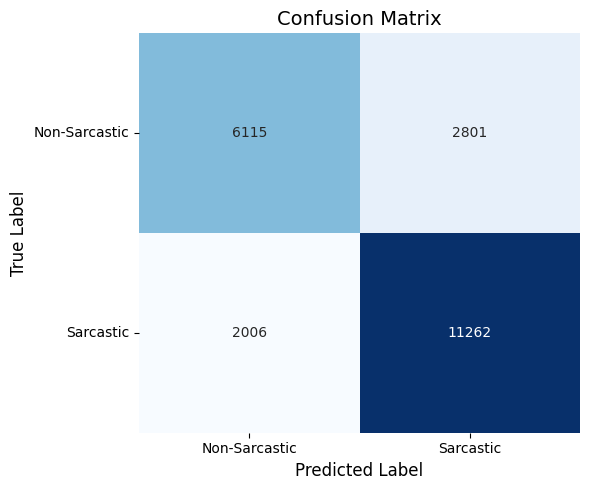

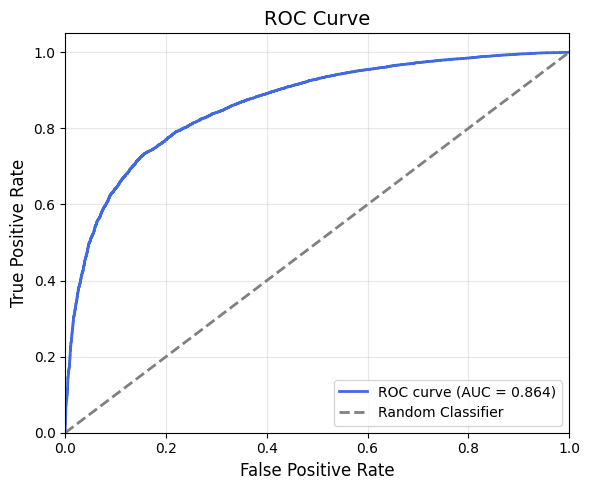

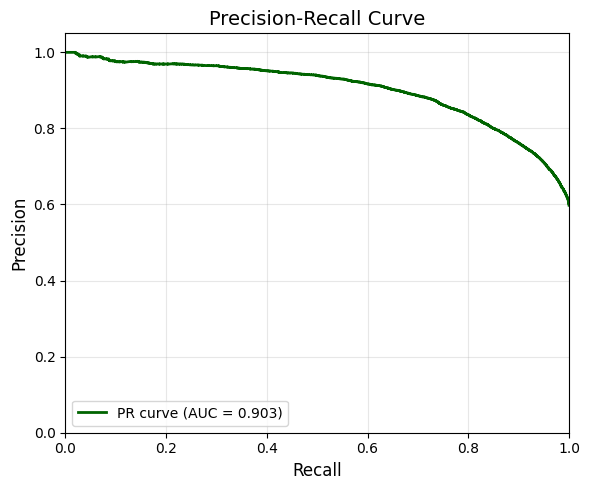


Plot generation complete.


In [17]:
def plot_confusion_matrix_mpl(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=classes, yticklabels=classes, cbar=False)

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    fig.tight_layout()
    return fig, ax

def plot_roc_curve_mpl(fpr, tpr, roc_auc, title='ROC Curve'):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(fpr, tpr, color='royalblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig, ax

def plot_precision_recall_curve_mpl(precision, recall, pr_auc, title='Precision-Recall Curve'):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig, ax

best_model_path = os.path.join(output_dir, 'best_model')
model = RobertaForSequenceClassification.from_pretrained(best_model_path)
model = model.to(device)

print("\nEvaluating on test set...")
test_results = eval_model(model, test_loader, device)
test_loss = test_results['loss']
test_acc = test_results['accuracy']
test_f1 = f1_score(test_results['labels'], test_results['predictions'], average='weighted')

print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | F1 Score: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_results['labels'], test_results['predictions'], target_names=['Non-Sarcastic', 'Sarcastic']))

print("\nGenerating plots...")

# Confusion Matrix
cm = confusion_matrix(test_results['labels'], test_results['predictions'])
cm_fig, cm_ax = plot_confusion_matrix_mpl(cm, classes=['Non-Sarcastic', 'Sarcastic'])


# ROC Curve
# Get probabilities for the positive class
test_probs = torch.softmax(torch.tensor(test_results['logits']), dim=1)[:, 1].cpu().numpy()
fpr, tpr, _ = roc_curve(test_results['labels'], test_probs)
roc_auc = auc(fpr, tpr)
roc_fig, roc_ax = plot_roc_curve_mpl(fpr, tpr, roc_auc)


# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_results['labels'], test_probs)
pr_auc = auc(recall, precision)
pr_fig, pr_ax = plot_precision_recall_curve_mpl(precision, recall, pr_auc)

plt.show()

print("\nPlot generation complete.")

#### Error Analysis: Finding misclassified examples

In [18]:
predictions = test_results['predictions']
labels = test_results['labels']
logits = test_results['logits']

misclassified_indices = np.where(predictions != labels)[0]

confidence_scores = np.max(torch.softmax(torch.tensor(logits), dim=1).numpy(), axis=1)

misclassified_df = pd.DataFrame({
    'text': test_df['comment'].iloc[misclassified_indices].values,
    'true_label': labels[misclassified_indices],
    'predicted_label': predictions[misclassified_indices],
    'confidence': confidence_scores[misclassified_indices],
    'subreddit': test_df['subreddit'].iloc[misclassified_indices].values
})

misclassified_df = misclassified_df.sort_values(by='confidence', ascending=False)

print("\nHigh-confidence misclassifications:")
for i, row in misclassified_df.head(5).iterrows():
    true_label = "Sarcastic" if row['true_label'] == 1 else "Non-Sarcastic"
    pred_label = "Sarcastic" if row['predicted_label'] == 1 else "Non-Sarcastic"

    print(f"\nExample from r/{row['subreddit']}:")
    print(f"Text: {row['text'][:200]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print(f"Confidence: {row['confidence']:.4f}")

def plot_misclassifications_by_subreddit(misclassified_df):
    # Count misclassifications by subreddit
    subreddit_counts = misclassified_df['subreddit'].value_counts().reset_index()
    subreddit_counts.columns = ['subreddit', 'count']

    # Calculate total counts by subreddit in test set
    total_by_subreddit = test_df['subreddit'].value_counts().reset_index()
    total_by_subreddit.columns = ['subreddit', 'total']

    # Merge to calculate error rate
    error_rates = pd.merge(subreddit_counts, total_by_subreddit, on='subreddit')
    error_rates['error_rate'] = error_rates['count'] / error_rates['total']

    # Filter to top subreddits by volume
    top_subreddits = error_rates.sort_values('total', ascending=False).head(15)

    fig = px.bar(
        top_subreddits,
        x='subreddit',
        y='error_rate',
        color='total',
        color_continuous_scale='Viridis',
        labels={'error_rate': 'Misclassification Rate', 'subreddit': 'Subreddit', 'total': 'Total Comments'},
        title='Misclassification Rate by Subreddit'
    )

    fig.update_layout(
        width=900,
        height=500,
        xaxis={'categoryorder': 'total descending'},
        yaxis={'tickformat': '.0%'}
    )

    return fig

# Visualize misclassifications by subreddit
subreddit_errors_fig = plot_misclassifications_by_subreddit(misclassified_df)
subreddit_errors_fig.show()

def predict_sarcasm(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()
    prediction = np.argmax(probs)

    return {
        'text': text,
        'is_sarcastic': bool(prediction),
        'confidence': float(probs[prediction]),
        'sarcasm_score': float(probs[1])
    }


High-confidence misclassifications:

Example from r/politics:
Text: I am republican-leaning mostly, but I still don't think that the Democratic Party is off by as far as this title suggests....
True Label: Sarcastic
Predicted Label: Non-Sarcastic
Confidence: 0.9964

Example from r/Libertarian:
Text: obviously...
True Label: Non-Sarcastic
Predicted Label: Sarcastic
Confidence: 0.9960

Example from r/news:
Text: I've only read the first Game of Thrones but if this is true then Robin is going to be the biggest bad ass of the series....
True Label: Sarcastic
Predicted Label: Non-Sarcastic
Confidence: 0.9950

Example from r/politics:
Text: There's a large group of actions by this non acting administration supporting your bullshit argument....
True Label: Sarcastic
Predicted Label: Non-Sarcastic
Confidence: 0.9949

Example from r/Conservative:
Text: How did that happen?...
True Label: Sarcastic
Predicted Label: Non-Sarcastic
Confidence: 0.9947


#### Demo Example:

In [21]:
# Demo examples, sampled from online sources.
demo_texts = [
    "The government is really efficient at handling this crisis.",
    "Climate change is a serious threat that requires immediate action.",
    "I absolutely love it when politicians lie to my face. Such integrity!",
    "These healthcare reforms will definitely solve all our problems overnight.",
    "Thanks for cutting funding to education, that's exactly what we needed."
]

print("\nSarcasm Prediction Demo:")
for text in demo_texts:
    result = predict_sarcasm(text, model, tokenizer, device)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {'Sarcastic' if result['is_sarcastic'] else 'Non-Sarcastic'}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Sarcasm Score: {result['sarcasm_score']:.4f}")

demo_results = [predict_sarcasm(text, model, tokenizer, device) for text in demo_texts]
demo_df = pd.DataFrame(demo_results)

# Truncate long texts
demo_df['short_text'] = demo_df['text'].apply(lambda x: x[:50] + "..." if len(x) > 50 else x)

sarcasm_scores_fig = px.bar(
    demo_df,
    x='short_text',
    y='sarcasm_score',
    color='sarcasm_score',
    color_continuous_scale='RdBu_r',
    labels={'sarcasm_score': 'Sarcasm Score', 'short_text': 'Text'},
    title='Sarcasm Scores for Example Texts'
)

sarcasm_scores_fig.update_layout(
    width=800,
    height=500,
    yaxis={'range': [0, 1]},
    xaxis={'categoryorder': 'total descending'}
)

sarcasm_scores_fig.show()

def extract_important_tokens(model, tokenizer, device, batch_size=32):
    classifier_weights = model.classifier.out_proj.weight.cpu().detach().numpy()[1]
    word_embeddings = model.roberta.embeddings.word_embeddings.weight.cpu().detach().numpy()

    token_importances = np.zeros(word_embeddings.shape[0])

    for i in range(0, word_embeddings.shape[0], batch_size):
        end_idx = min(i + batch_size, word_embeddings.shape[0])
        batch_embeddings = word_embeddings[i:end_idx]

        # Rank by how much it would influence the final layer
        batch_importances = np.dot(batch_embeddings, classifier_weights)
        token_importances[i:end_idx] = batch_importances

    tokens = tokenizer.convert_ids_to_tokens(range(len(token_importances)))
    token_df = pd.DataFrame({
        'token': tokens,
        'importance': token_importances
    })

    # Filter special tokens and tokens with low frequency
    token_df = token_df[~token_df['token'].str.startswith(('<', '[', '##'))]
    token_df['abs_importance'] = np.abs(token_df['importance'])
    token_df = token_df.sort_values('abs_importance', ascending=False)

    return token_df

token_importances = extract_important_tokens(model, tokenizer, device)

def plot_top_tokens(token_importances, n=15):
    # Get top positive tokens
    top_positive = token_importances[token_importances['importance'] > 0].head(n)
    # Get top negative tokens
    top_negative = token_importances[token_importances['importance'] < 0].head(n)
    top_tokens = pd.concat([top_positive, top_negative])

    fig = px.bar(
        top_tokens,
        x='token',
        y='importance',
        color='importance',
        color_continuous_scale='RdBu_r',
        title=f'Top {n} Tokens by Importance to Sarcasm Detection',
        labels={'token': 'Token', 'importance': 'Importance Score'}
    )

    fig.update_layout(
        width=900,
        height=600,
        xaxis={'categoryorder': 'total descending'},
        yaxis_title="Impact on Sarcasm Score",
        xaxis_title="",
        font=dict(size=12)
    )

    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=0,
        x1=len(top_tokens) - 0.5,
        y1=0,
        line=dict(color="black", width=1, dash="dash")
    )

    fig.add_annotation(
        x=n/2,
        y=top_positive['importance'].max() * 1.1,
        text="Tokens that increase sarcasm score",
        showarrow=False,
        font=dict(size=14, color="darkred")
    )

    fig.add_annotation(
        x=n + n/2,
        y=top_negative['importance'].min() * 1.1,
        text="Tokens that decrease sarcasm score",
        showarrow=False,
        font=dict(size=14, color="darkblue")
    )

    return fig

top_tokens_fig = plot_top_tokens(token_importances)
top_tokens_fig.show()

print("\nFinal Model Summary:")
print(f"Model Type: Distilled RoBERTa (distilroberta-base)")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

print("\nHyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: 2e-5")
print(f"Epochs: {epochs}")
print(f"Max Sequence Length: 128")

# Compare with baseline models
model_comparison = pd.DataFrame({
    'Model': ['Bag of Words', 'TF-IDF', 'TF-IDF N-gram', 'RoBERTa'],
    'Accuracy': [0.6915, 0.7123, 0.7123, test_acc],
    'F1 Score': [0.6880, 0.7090, 0.7090, test_f1]
})

# Visualize model comparison
model_comparison_fig = px.bar(
    model_comparison,
    x='Model',
    y=['Accuracy', 'F1 Score'],
    barmode='group',
    title='Model Performance Comparison',
    labels={'value': 'Score', 'variable': 'Metric'}
)

model_comparison_fig.update_layout(
    width=800,
    height=500,
    yaxis={'range': [0.65, 0.95]},
)

model_comparison_fig.show()
print("\nAll results and visualizations have been saved to:", output_dir)


Sarcasm Prediction Demo:

Text: The government is really efficient at handling this crisis.
Prediction: Sarcastic
Confidence: 0.9807
Sarcasm Score: 0.9807

Text: Climate change is a serious threat that requires immediate action.
Prediction: Sarcastic
Confidence: 0.7048
Sarcasm Score: 0.7048

Text: I absolutely love it when politicians lie to my face. Such integrity!
Prediction: Sarcastic
Confidence: 0.9881
Sarcasm Score: 0.9881

Text: These healthcare reforms will definitely solve all our problems overnight.
Prediction: Sarcastic
Confidence: 0.9907
Sarcasm Score: 0.9907

Text: Thanks for cutting funding to education, that's exactly what we needed.
Prediction: Sarcastic
Confidence: 0.9881
Sarcasm Score: 0.9881



Final Model Summary:
Model Type: Distilled RoBERTa (distilroberta-base)
Test Accuracy: 0.7833
Test F1 Score: 0.7814
Training Time: 2356.93 seconds

Hyperparameters:
Batch Size: 16
Learning Rate: 2e-5
Epochs: 5
Max Sequence Length: 128



All results and visualizations have been saved to: /content/drive/MyDrive/SarcasmDetection/roberta_model
